# IE509 - Projeto 3
## Vitor Nagata - RA 178499

### 1 - Introdução

Começamos importanto os audios para o python

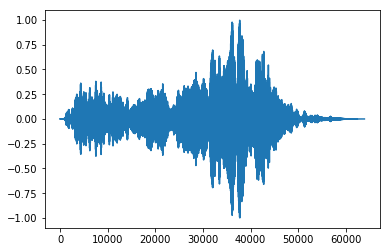

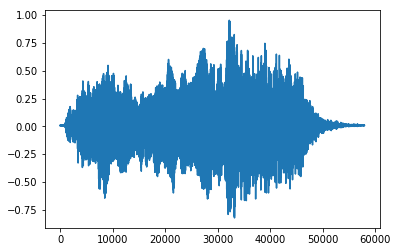

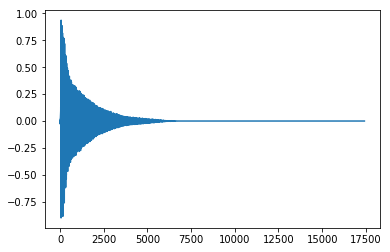

In [2]:
import soundfile  as sf
import matplotlib.pyplot as plt

conv1, samplerate_conv1 = sf.read('convolucao1.wav')
plt.plot(conv1)
plt.show()

elefante, samplerate_elefante = sf.read('elefante.wav')
plt.plot(elefante)
plt.show()

garrafa, samplerate_conv1 = sf.read('Garrafa.wav')
plt.plot(garrafa)
plt.show()

### Gerando ruidos
Ruído de excitação w[k]:

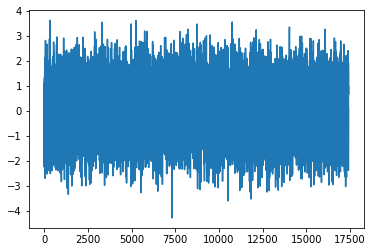

In [3]:
import numpy as np

# media 0, variancia 1
w = np.random.normal(0, 1, len(garrafa))
plt.plot(w)

Ruído de leitura n[k]:

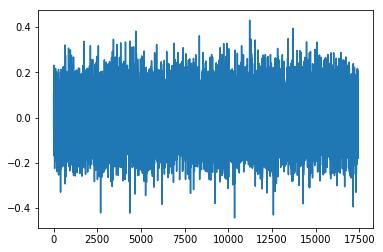

In [4]:
# media 0 e variancia 0.01 (desvio padrao = 0.1)
n_read = np.random.normal(0, 0.1, len(garrafa))
plt.plot(n_read)

### Resposta ao impulso ruidosa

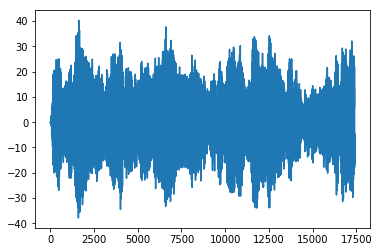

In [5]:
r = np.convolve(garrafa, w, mode='full')[:len(garrafa)] + n_read
plt.plot(r)

### 2 - Estimação por Correlação

#### 2.1) Estimação da correlação pela média amostral
Ao passarmos um sinal x[k] por um filtro com resposta h[k], temos a seguinte expressão dada pela convolução

$$y[k] = x[k] * h[k] = \sum_{m = -K}^{K} x[k]h[k-m]\$$

No nosso caso, para um sistema **causal** e: $x[k] = r[k]$, $h[k] = w[-k]$ e $y[k] = \frac{\rho[k]}{K}$
$$\rho[k] = \frac{1}{K}\sum_{m=0}^{K}r[k]w[m-k]$$

Portanto, obtivemos a correlação cruzada a partir de um filtro com resposta $w[-k]$

#### 2.2) Transformada de Fourrier de $\rho[k]$

Do sinal original, temos:

$$r[k] = w[k] * h[k] + n[k]$$

Passando pelo filtro com resposta w[-k], temos:
$$K\rho[k] = w[k] * h[k] * w[-k] + n[k] * w[-k]$$

Aplicando a transformada de Fourier:

$$P(f) = \frac{|W(f)|^2}{K} H(f) + \frac{W^*(f)}{K}N(f)$$

Calculando-se a esperança dessa equação, temos:

$$E[P(f)] = E\left[\frac{|W(f)|^2}{K} H(f)\right] + E\left[\frac{W^*(f)}{K}N(f)\right]$$

Como W, H e N são independentes:

$$E[P(f)] = \frac{1}{K} E[|W(f)|^2]E[H(f)] + \frac{1}{K}E[W^*(f)]E[N(f)]$$

Como a esperança do ruido branco é zero e a PSD é 1, ficamos com o seguinte estimador:

$$E[P(f)] = \frac{1}{K}E[H(f)]$$

#### 2.3) Implementando o estimador

Para calcular o estimador, utilizamos a função correlate do python, dividimos pelo número de amostras (média amostral) e pegamos os valores da segunda metade (parte que interessa da convolução)

17419

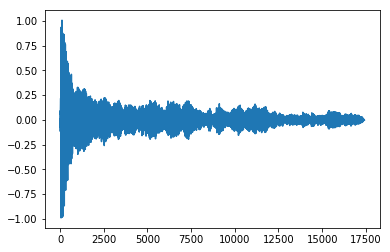

In [6]:
h_est = ((np.correlate(r, w, mode='full'))/len(garrafa))[len(garrafa)-2:-1]
plt.plot(h_est)
len(h_est)

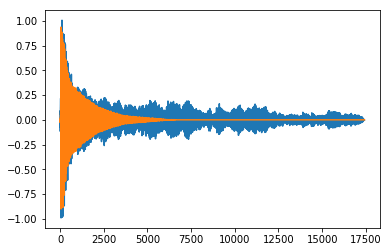

In [7]:
# diferenca visual entre a resposta original e o impulso estimado
plt.plot(h_est)
plt.plot(garrafa)
plt.show()

#### Calculo do erro entre o valor e a estimação

In [8]:
# diferenca quadratica
erro = (np.square(garrafa - h_est)).sum()

# normalizacao
erro = erro/((np.square(garrafa)).sum())

print(erro)

0.7201044417345092


### 3 - Melhorando a Correlação

Podemos melhorar a estimativa realizando varias medições da resposta ao impulso para várias realizações de ruido branco.
A medição será melhor estimada pela Lei dos Grandes números, que diz que quanto maior a quantidade de medições realizadas para o cálculo da média amostral, mais se aproximará a média amostral do valor esperado. Portanto, podemos realizar a mesma operação de estimação através da correlação cruzada e tirar a média amostral dessa nova correlação. 

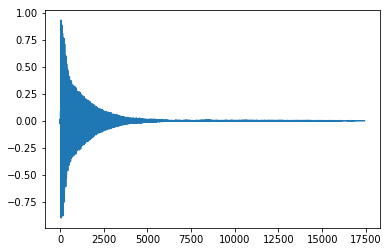

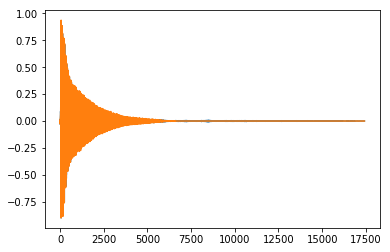

In [9]:
h_est_large_num = 0

for i in range(1000):
    w = np.random.normal(0, 1, len(garrafa))
    n_read = np.random.normal(0, 0.1,len(garrafa))
    r = np.convolve(garrafa, w, mode='full')[:len(garrafa)] + n_read
    
    h_est_large_num = h_est_large_num + ((np.correlate(r, w, mode='full'))/len(garrafa))[len(garrafa)-2:-1]
    
h_est_large_num = h_est_large_num/1000

# plot da nova estimativa
plt.plot(h_est_large_num)
plt.show()

# plot da nova estimativa e da resposta original sobrepostas
plt.plot(h_est_large_num)
plt.plot(garrafa)
plt.show()

In [15]:
# diferenca quadratica
erro_large_num = (np.square(garrafa - h_est_large_num)).sum()

# normalizacao
erro_large_num = erro_large_num/((np.square(garrafa)).sum())

print(erro_large_num)

0.21739324099461585


In [16]:
diff_erro = erro - erro_large_num
print(diff_erro)

0.5027112007398933


Redução do erro em 0.50 em relação ao tamanho da resposta ao impulso!

### 4 - Mínimo Erro Quadrático médio

#### Demostração da leitura na forma matricial

Do sistema original, temos:

$$r[k] = w[k] * h[k] + n[k]$$

Expandindo a convolução

$$r[k] = \left(\sum_{m=0}^{K} w[k-m]h[k]\right) + n[k]$$

Expandindo a somatória
$$r[k] = (w[k]h[k] + w[k-1]h[k] + \cdots + w[0]h[k]) + n[k]$$

Podemos reescrever:
$$r[k] = \begin{bmatrix}w[k] w[k-1] \cdots w[0]\end{bmatrix} \begin{bmatrix}h_0 \\ h_1 \\ \vdots \\ h_k\end{bmatrix}  + n[k]$$

Em notação matricial:
$$\mathbf{R}[k] = \mathbf{W}^T[k]\mathbf{h} + \mathbf{N}[k]$$

#### Estimando utilizando a matriz de Toeplitz

Gerando novamente a medição ruidosa:

In [17]:
# ruido de exitação
w = np.random.normal(0, 1, len(garrafa))
#w = np.random.normal(0, 1, size=(100,len(garrafa)))

# ruido de leitura
n_read = np.random.normal(0, 0.1, len(garrafa))
#n_read = np.random.normal(0, 0.1, size=(100, len(garrafa)))

# leitura com ruido

r = np.convolve(garrafa, w, mode='full')[:len(garrafa)] + n_read
# R = w * garrafa + n_read
# mean_lhs = np.mean(np.matmul(w, w.transpose()), axis=1)
# mean_rhs = np.mean(np.matmul(w, R.transpose()), axis=1)

Iremos utilizar a função solve_toeplitz do python utilizando a equação do roteiro:

$$E[\mathbf{W}[k]\mathbf{W}^T[k]]\mathbf{h} = E[\mathbf{W}[k]R[k]]$$

Onde queremos estimar **h** a partir dos valores $w[k]$ e $r[k]$

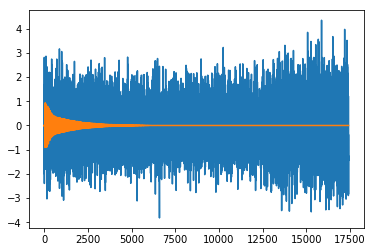

In [18]:
from scipy.linalg import solve_toeplitz, toeplitz

#solve_toeplitz resolve um problema do tipo T x = b
T = np.convolve(w, w, mode='full')
b = np.convolve(w, r, mode='full')
#T = np.transpose(w) * w
#b = np.transpose(w) * r

h_toep = solve_toeplitz(T, b)

plt.plot(h_toep[:len(garrafa)])
plt.plot(garrafa)
plt.show()

**Obs:** Infelizmente, não consegui um bom resultado neste estimador. Pelo que entendi, deveriam ser feitas várias realizações para w[k] e r[k] para o cálculo das esperanças na solução da matriz de toeplitz, mas encontrei problemas quando tentei realizar as operações matriciais de multiplicações, então tentei implementar a solução com apenas uma realização (o que não resultou em um bom estimador de fato pela imagem aciima).